In [1]:
#coding: utf-8
import cython
import numpy as np
import pandas as pd
import scipy
import pymysql
from numba import jit
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import wrapt
import time
import os
from multiprocessing import Pool
%matplotlib inline
%load_ext Cython

In [2]:
def RBreaker(yes_high,yes_low,yes_close):
    s_setup=yes_high+0.35*(yes_close-yes_low)
    b_setup=yes_low-0.35*(yes_high-yes_close)
    senter=1.07/2*(yes_high+yes_low)-0.07*yes_low
    benter=1.07/2*(yes_high+yes_low)-0.07*yes_high
    b_break=s_setup+0.25*(s_setup-b_setup)
    s_break=b_setup-0.25*(s_setup-b_setup)
    return [s_setup,b_setup,senter,benter,b_break,s_break]

In [143]:
def rbreaker(category):
    intra_df=pd.read_csv('%s_intraday.csv'%category.lower(),encoding='gbk')
#     intra_df=intra_df.dropna(axis=1,how='all')
#     intra_df=intra_df.rename(columns={'time':'update_date'})
    intra_df['update_date']=pd.to_datetime(intra_df['update_date'])

    interday_df=pd.read_csv('%s_interday.csv'%category.lower(),encoding='gbk',header=3)
    interday_df['Date']=pd.to_datetime(interday_df['Date'])
    interday_df=interday_df.rename(columns={'Date':'update_date'})
    interday_df['open']=interday_df['open'].astype(float)
    interday_df['high']=interday_df['high'].astype(float)
    interday_df['low']=interday_df['low'].astype(float)
    interday_df['close']=interday_df['close'].astype(float)

    interday_df['high_yes']=interday_df['high'].shift(1)
    interday_df['low_yes']=interday_df['low'].shift(1)
    interday_df['close_yes']=interday_df['close'].shift(1)

    rb=map(RBreaker,interday_df['high_yes'],interday_df['low_yes'],interday_df['close_yes'])

    rb=pd.DataFrame(rb,columns=['s_setup','b_setup','senter','benter','b_break','s_break'])
    rb['update_date']=interday_df['update_date']

    rb=rb.rename(columns={'update_date':'date'})
    rb['date']=pd.to_datetime(rb['date'])
#     #干掉夜盘
#     intra_df=intra_df[intra_df['update_date'].apply(lambda x:x.hour>=9)==True]
#     intra_df=intra_df[intra_df['update_date'].apply(lambda x:x.hour<=15)==True]
    intra_df['date']=intra_df['update_date'].apply(lambda x: x.date() if x.hour>=9 and x.hour<=15 else pd.to_datetime(np.nan))
    intra_df['date']=intra_df['date'].fillna(method='bfill')
#     intra_df['date']=intra_df['update_date'].apply(lambda x:x.date() if x.hour<21 else pd.to_datetime(x+np.timedelta64(1,'D')).date())
    intra_df['date']=pd.to_datetime(intra_df['date'])

    intra_df=pd.merge(intra_df,rb,on=['date'],how='inner')

    intra_df=intra_df.dropna(axis=0)

    intra_df=intra_df.drop(['volume'],axis=1)

    intra_df_cop=pd.DataFrame()
    for i,j in intra_df.groupby(['date']):
        j=j.sort('update_date')
        
        stop_loss_point_1=list(j['open'])[0]
        try:
            stop_loss_point_2=list(j[j['update_date'].apply(lambda x:x.hour<21 and x.hour>=9)==True]['open'])[0]
        except:
            stop_loss_point_2=stop_loss_point_1
        j['high_max']=j['high'].cummax()
        j['low_min']=j['low'].cummin()
        
        
        col_list=list(j.columns)
        open_lab=col_list.index('open')
        high_lab=col_list.index('high')
        low_lab=col_list.index('low')
        close_lab=col_list.index('close')
        s_setup_lab=col_list.index('s_setup')
        b_setup_lab=col_list.index('b_setup')
        senter_lab=col_list.index('senter')
        benter_lab=col_list.index('benter')
        b_breaker_lab=col_list.index('b_break')
        s_breaker_lab=col_list.index('s_break')
        high_max_lab=col_list.index('high_max')
        low_min_lab=col_list.index('low_min')
        update_date_lab=col_list.index('update_date')

        p_mat=j.as_matrix()
        sig=np.zeros(p_mat.shape[0],dtype=np.float)
        for k in range(1,p_mat.shape[0]-1):
            if p_mat[k,update_date_lab].hour<21 and p_mat[k,update_date_lab].hour>=9:
                stop_loss_point=stop_loss_point_2
            else:
                stop_loss_point=stop_loss_point_1
            #突破做多
            if p_mat[k,high_lab]>p_mat[k,b_breaker_lab] and stop_loss_point<p_mat[k,s_setup_lab]:
                sig[k+1]=1
            elif p_mat[k,low_lab]>stop_loss_point and sig[k]==1:
                sig[k+1]=1
            elif p_mat[k,low_lab]<=stop_loss_point and sig[k]==1:
                sig[k+1]=0
            #突破做空
            elif p_mat[k,low_lab]<p_mat[k,s_breaker_lab] and stop_loss_point>p_mat[k,b_setup_lab]:
                sig[k+1]=-1
            elif p_mat[k,high_lab]<stop_loss_point and sig[k]==-1:
                sig[k+1]=-1
            elif p_mat[k,high_lab]>=stop_loss_point and sig[k]==-1:
                sig[k+1]=0
            #反转做多做空
            else:
                if p_mat[k,high_max_lab]<p_mat[k,b_breaker_lab] and p_mat[k,high_max_lab]>p_mat[k,s_setup_lab] and p_mat[k,low_lab]<p_mat[k,senter_lab]:
                    sig[k+1]=-1
                elif p_mat[k,low_min_lab]>p_mat[k,s_breaker_lab] and p_mat[k,low_min_lab]<p_mat[k,b_setup_lab] and p_mat[k,high_lab]>p_mat[k,benter_lab]:
                    sig[k+1]=1
                else:
                    sig[k+1]=0



        j['sig']=sig
        intra_df_cop=intra_df_cop.append(j)

    intra_df_cop['return']=intra_df_cop['pctchange']*intra_df_cop['sig']

    intra_df_cop['cum']=intra_df_cop['return'].cumsum()
    return intra_df_cop

In [144]:
def select_component(pool_list):
    name=locals()
    std_frame=pd.DataFrame()
    for item in pool_list:
        name['%s'%item]=rbreaker(str(item))
        tmp_std=pd.DataFrame(name['%s'%item].groupby(["date"]).pctchange.std())
        tmp_std=pd.rolling_max(tmp_std,10)
        tmp_std=tmp_std.rename(columns={"pctchange":"%s"%item})
        std_frame=pd.concat([std_frame,tmp_std],axis=1,join="outer")
    col_list=list(std_frame.columns)
    date_array=np.array(std_frame.index)
    std_mat=std_frame.as_matrix()
    N=len(date_array)
    selected_df=pd.DataFrame()
    for i in range(N-1):
        t=std_mat[i,:]
        idx_min=np.argmin(t)
        cat=col_list[idx_min]
        d=date_array[i+1]
        print d,cat
#         tt=name['%s'%cat][name['%s'%cat]['date']==d][['update_date','sig','return']]
        tt=name['%s'%cat][name['%s'%cat]['date']==d]
        selected_df=selected_df.append(tt)
    return selected_df

In [145]:
pool_list=['A','C','CF','CS','M','RM','Y']

In [146]:
pool_list_1=['AL','CU','ZN']

In [147]:
a=select_component(pool_list)

/Users/liyuefan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


2016-03-10T00:00:00.000000000 A
2016-03-11T00:00:00.000000000 A
2016-03-14T00:00:00.000000000 A
2016-03-15T00:00:00.000000000 A
2016-03-16T00:00:00.000000000 A
2016-03-17T00:00:00.000000000 A
2016-03-18T00:00:00.000000000 A
2016-03-21T00:00:00.000000000 A
2016-03-22T00:00:00.000000000 A
2016-03-23T00:00:00.000000000 M
2016-03-24T00:00:00.000000000 M
2016-03-25T00:00:00.000000000 M
2016-03-28T00:00:00.000000000 A
2016-03-29T00:00:00.000000000 Y
2016-03-30T00:00:00.000000000 Y
2016-03-31T00:00:00.000000000 Y
2016-04-01T00:00:00.000000000 Y
2016-04-05T00:00:00.000000000 Y
2016-04-06T00:00:00.000000000 Y
2016-04-07T00:00:00.000000000 Y
2016-04-08T00:00:00.000000000 Y
2016-04-11T00:00:00.000000000 CF
2016-04-12T00:00:00.000000000 M
2016-04-13T00:00:00.000000000 A
2016-04-14T00:00:00.000000000 A
2016-04-15T00:00:00.000000000 A
2016-04-18T00:00:00.000000000 A
2016-04-19T00:00:00.000000000 A
2016-04-20T00:00:00.000000000 A
2016-04-21T00:00:00.000000000 Y
2016-04-22T00:00:00.000000000 M
2016-04

In [148]:
a['cum']=a['return'].cumsum()

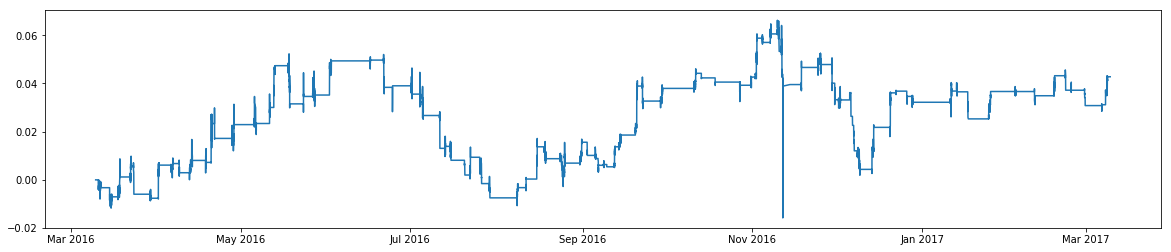

In [149]:
plt.figure(figsize=(20,4))
plt.plot(a['update_date'],a['cum'])

In [150]:
b=a[a['update_date']>=pd.to_datetime('2016-11-11 21:00:00')]
b=b[b['update_date']<=pd.to_datetime('2016-11-12 16:00:00')]

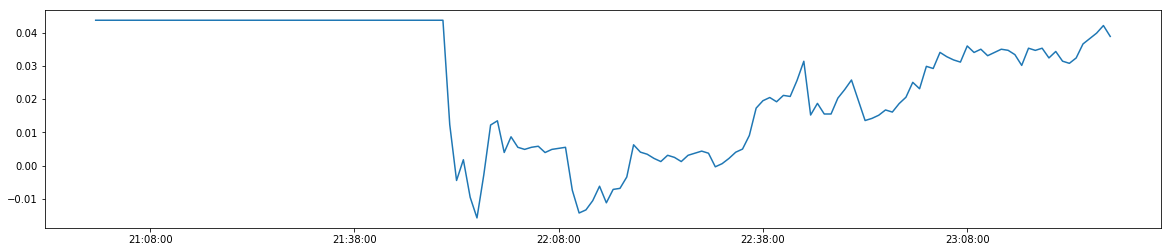

In [151]:
plt.figure(figsize=(20,4))
plt.plot(b['update_date'],b['cum'])

In [152]:
M=pd.read_csv('cf_intraday.csv',encoding='gbk')
M['update_date']=pd.to_datetime(M['update_date'])

In [153]:
m=M[M['update_date']>=pd.to_datetime('2016-11-11 21:00:00')]
m=m[m['update_date']<=pd.to_datetime('2016-11-12 16:00:00')]

In [154]:
a_s=a[a['update_date']>=pd.to_datetime('2016-11-11 21:00:00')]
a_s=a_s[a_s['update_date']<=pd.to_datetime('2016-11-12 16:00:00')]

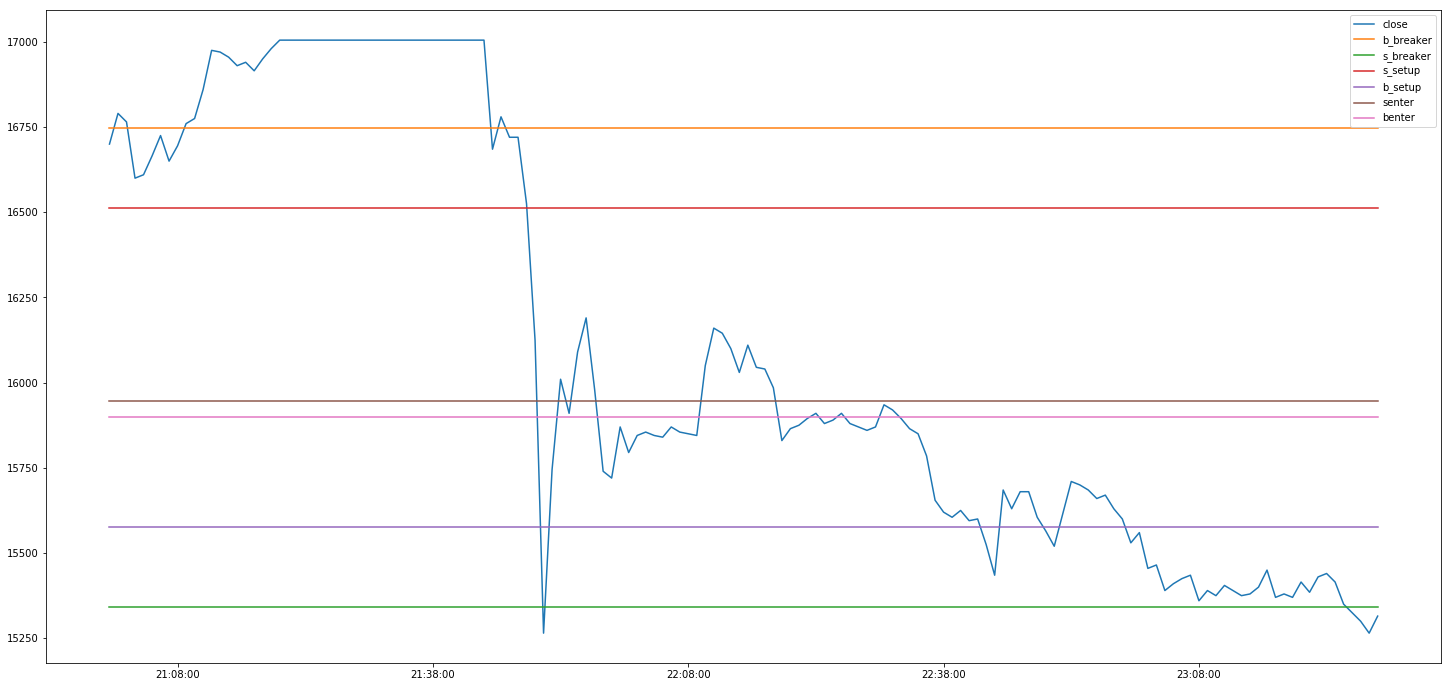

In [164]:
plt.figure(figsize=(25,12))
plt.plot(m['update_date'],m['close'],label='close')
plt.plot(a_s['update_date'],a_s['b_break'],label='b_breaker')
plt.plot(a_s['update_date'],a_s['s_break'],label='s_breaker')
plt.plot(a_s['update_date'],a_s['s_setup'],label='s_setup')
plt.plot(a_s['update_date'],a_s['b_setup'],label='b_setup')
plt.plot(a_s['update_date'],a_s['senter'],label='senter')
plt.plot(a_s['update_date'],a_s['benter'],label='benter')

plt.legend()

In [156]:
a=a.rename(columns={'return':'r'})
ad=pd.DataFrame(a.groupby(['date']).r.sum())

In [157]:
ad['cum']=ad['r'].cumsum()

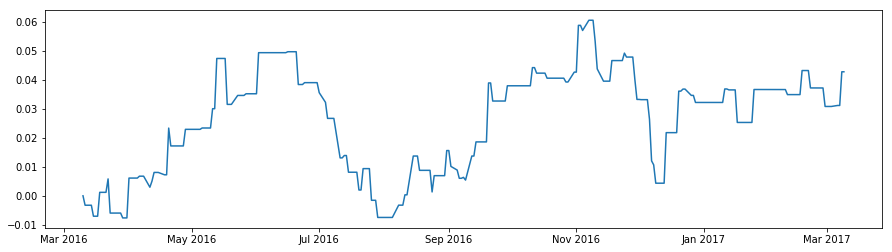

In [158]:
plt.figure(figsize=(15,4))
plt.plot(ad['cum'])